# Debug Sjoin + overlay 

`overlay` is taking a long time, but since there's a dissolve, it's basically 1 row for T-Mobile compared to 1 row for the district boundary. Might be able to treat them as GeoSeries and see if it can go through faster.

`difference` can also take multiple rows for T-Mobile compared to 1 row for district boundary. In this case, the dissolve for where there's no coverage for T-Mobile should take place after the difference is taken.

* `difference`: https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.difference.html


In [1]:
import dask.dataframe as dd
import dask_geopandas as dg
import geopandas as gpd
import pandas as pd
from calitp_data_analaysis import geography_utils, utils
import folium

from calitp.sql import to_snakecase
import A1_provider_prep
import A2_other
import A3_analysis

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
pd.options.display.max_columns = 100
pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

### 1/9/22 Rerun AT&T because it doesn't look accurate

In [3]:
att = dg.read_parquet("ATT.parquet")

In [4]:
# att_gdf = att.compute()

In [5]:
districts = A1_provider_prep.get_districts()

In [10]:
districts.drop(columns = ["geometry"])

,district
0,1
1,2
2,3
3,4
4,5
5,6
6,8
7,10
8,11
9,12


In [6]:
# m

### District 9 Test T-Mobile 
* Grab the file that already has already been `sjoin`.

In [7]:
# Subset
d9 =  districts[districts.district == 9]

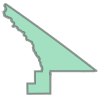

In [11]:
d9.geometry.iloc[0]

In [8]:
tmobile_d9 = gpd.read_parquet("gs://calitp-analytics-data/data-analyses/cellular_coverage/tmobile_d9.parquet")

In [9]:
clipped_tmobile_d9= tmobile_d9.clip(d9.geometry.iloc[0])

In [66]:
dissolve_tmobile_d9 = clipped_tmobile_d9.dissolve(by = "district")

<AxesSubplot:>

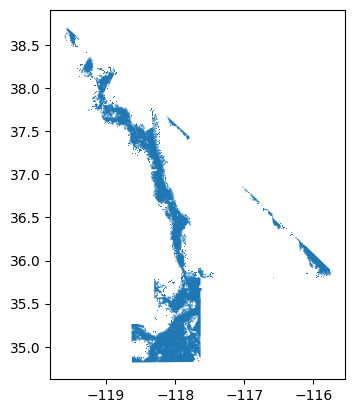

In [67]:
dissolve_tmobile_d9.plot()

In [68]:
difference_tmobile_d9 = d9.difference(dissolve_tmobile_d9.geometry.iloc[0])

<AxesSubplot:>

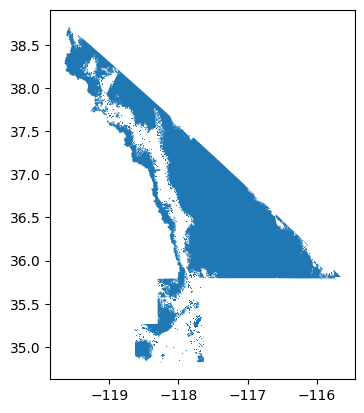

In [69]:
difference_tmobile_d9.plot()

### Debug District 2
* Why is D2 areas without coverage showing up as with coverage after difference
* Break apart `iloc_find_difference_district` function in `A1_provider.py`

In [29]:
# Subset
d2 =  districts[districts.district == 2]

In [30]:
# Sjoin
sjoin_d2 = dg.sjoin(
        att[["geometry"]], 
        d2, 
        how="inner", 
        predicate="intersects"
    ).drop(columns = "index_right")

In [31]:
# Compute
sjoin_d2 = sjoin_d2.compute()

In [32]:
# Plot ATT against districts
m = d2.explore(
    "district",
    tiles = "CartoDB positron",
    color = "Red",
    name="districts",
    width=800,
    height=400,
)

/opt/conda/lib/python3.9/site-packages/mapclassify/classifiers.py:891: RuntimeWarning: invalid value encountered in double_scalars


In [33]:
# ATT provider
m = sjoin_d2.explore(
    m=m, legend = False
)

In [34]:
# m

In [35]:
len(sjoin_d2)

9

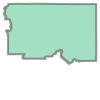

In [36]:
d2.geometry.iloc[0]

In [37]:
clipped_s2 = sjoin_d2.clip(d2)

In [38]:
clipped_s2_dissolved = clipped_s2.dissolve(by = "district")

<AxesSubplot:>

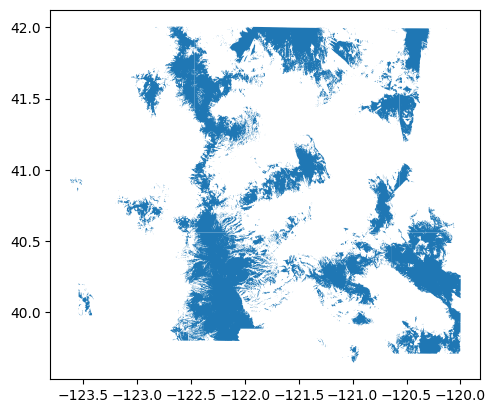

In [39]:
clipped_s2.plot()

In [40]:
test = d2.difference(clipped_s2_dissolved.geometry.iloc[0])

In [41]:
type(test)

geopandas.geoseries.GeoSeries

### Debug District 10

In [42]:
# Subset
d10 =  districts[districts.district == 10]

<AxesSubplot:>

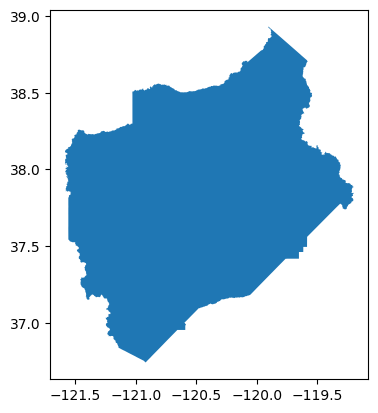

In [43]:
d10.plot()

In [44]:
sjoin_d10 = dg.sjoin(
        att[["geometry"]], 
        d10, 
        how="inner", 
        predicate="intersects"
    ).drop(columns = "index_right")

In [45]:
sjoin_d10 = sjoin_d10.compute()

In [46]:
clipped_10 = sjoin_d10.clip(d10)

In [47]:
clipped_10_dissolved = clipped_10.dissolve(by = "district")

<AxesSubplot:>

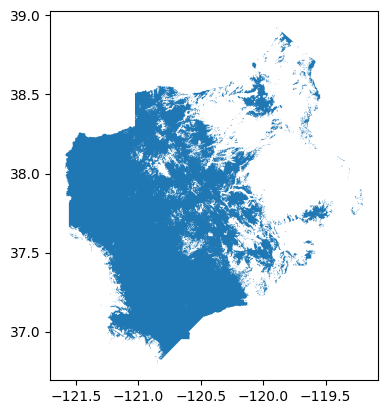

In [48]:
clipped_10_dissolved.plot()

In [49]:
no_coverage_d10 = d10.difference(
        clipped_10_dissolved.geometry.iloc[0], 
    ).reset_index()

<AxesSubplot:>

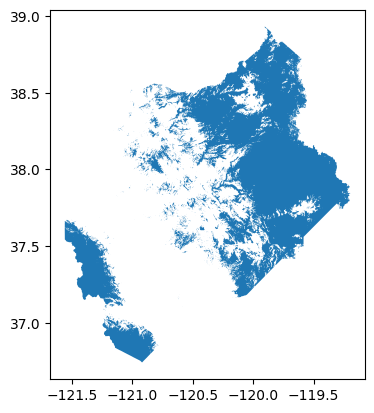

In [50]:
no_coverage_d10.plot()

### Try function

In [52]:
# tmobile_d2 = gpd.read_parquet("gs://calitp-analytics-data/data-analyses/cellular_coverage/tmobile_d2.parquet")

In [53]:
# d2 =  districts[districts.district == 2]

In [54]:
# tmobile_d2.plot()

In [55]:
def clip_dissolve_difference(
    sjoined_gdf: gpd.GeoDataFrame,
    district_gdf:  gpd.GeoDataFrame):
    
    # Clip 
    clipped = sjoined_gdf.clip(district_gdf.geometry.iloc[0])
    
    # Dissolve clipped gdf to one line
    dissolved = clipped.dissolve(by = "district")
    
    # Find the difference
    no_coverage = district_gdf.difference(dissolved.geometry.iloc[0])
    
    return no_coverage

In [56]:
# tmobile_d2_test = clip_dissolve_difference(tmobile_d2, d2)

### Don't run this beyond this - Alameda County

In [ ]:
counties = A1_provider_prep.get_counties()

In [ ]:
alameda_only = counties[counties.county_name == 'Alameda']

In [ ]:
alameda_only.plot()

In [ ]:
# sjoin original AT&T map against D4
# Just breaking apart iloc find difference district
sjoin_alameda_att = dg.sjoin(
        att, 
        alameda_only, 
        how="inner", 
        predicate = "intersects"
    ).drop(columns = "index_right")

In [ ]:
sjoin_alameda_att.compute().plot()

In [ ]:
# sjoin original AT&T map against D4
# Just breaking apart iloc find difference district
clip_alameda_att = dg.clip(
        att, 
        alameda_only)

In [ ]:
clip_alameda_att.compute().plot()

In [ ]:
clip_alameda_att2 = clip_alameda_att2.compute() 

In [ ]:
# Create a new route length for portions covered by cell coverage
overlay_df3 = A2_analysis.dissolve_summarize(overlay_df2)

In [ ]:
overlay_df3.drop(columns=['geometry']).sort_values('percentage_route_covered')

In [ ]:
kern = A1_provider_prep.correct_kern()

In [ ]:
kern = att.difference(
        kern.geometry.iloc[0], 
    ).reset_index()

In [ ]:
kern2 = A1_provider_prep.simplify_geometry(kern)

In [ ]:
# Overlay
kern_routes = A2_analysis.comparison(unique_routes,kern2)
kern_routes = A2_analysis.dissolve_summarize(kern_routes)

In [ ]:
kern_routes.drop(columns=['geometry']).sort_values('percentage_route_covered')

### iloc function county

In [ ]:
def find_difference_county(
    provider_df: dg.GeoDataFrame, 
    county_df: gpd.GeoDataFrame,
) -> dg.GeoDataFrame:
    
    # Clip provider to CT district
    provider_county = dg.sjoin(
        provider_df, 
        county_df, 
        how="inner", 
        predicate="intersects"
    ).drop(columns = "index_right")
    
    # Compute back to normal gdf
    provider_county = provider_county.compute()
    
    # Get areas without coverage
    no_coverage = provider_county.difference(
        county_df.geometry.iloc[0], 
    ).reset_index()
    
    # Turn to gdf
    no_coverage = (no_coverage.reset_index()
                  .dissolve()
                  .rename(columns = {0: 'geometry'})
                  [["geometry"]]
                 )
    # Set geometry
    no_coverage = no_coverage.set_geometry('geometry')
    
    return no_coverage

In [ ]:
counties.plot()

In [ ]:
kern.plot()

In [ ]:
counties.geometry.is_valid.all()

In [ ]:
verizon = utilities.load_verizon()

In [ ]:
kern_v = find_difference_county(verizon, kern)

In [ ]:
county_list = counties.county_name.sort_values().unique().tolist()

In [ ]:
def complete_difference_provider_county_level(
    provider_df: dg.GeoDataFrame, 
    county_df: gpd.GeoDataFrame,
    provider_name: str,) -> dg.GeoDataFrame:
    full_gdf = pd.DataFrame()
    
    county_list = county_df.county_name.sort_values().unique().tolist()
    
    for i in county_list:
        result = find_difference_county(
            provider_df, 
            county_df[county_df.county_name==i]
        )

        full_gdf = dd.multi.concat([full_gdf, result], axis=0)
        print(f"done for {i}")
    full_gdf = full_gdf.compute()
    
    utils.geoparquet_gcs_export(full_gdf, utilities.GCS_FILE_PATH, f"{provider_name}_no_coverage_complete_CA")
    return full_gdf

In [ ]:
# test = complete_difference_provider_county_level(verizon, counties, 'verizon',)

In [ ]:
test_ver.plot()

#### iloc testing

In [ ]:
# For files that are split apart by counties/districts
# That needs to be combined together to create a full California map
# https://www.geeksforgeeks.org/how-to-read-multiple-data-files-into-pandas/
def concat_all_areas(file_list:list, provider_name:str):
    main_dataframe = pd.DataFrame(gpd.read_parquet(file_list[0]))
    for i in range(1,len(file_list)):
        data = pd.gpd.read_parquet(file_list[i])
        df = pd.DataFrame(data)
        full_dataframe = dd.multi.concat([full_dataframe,df],axis=1)
        
    full_dataframe = full_dataframe.compute()
    
    utils.geoparquet_gcs_export(full_gdf, utilities.GCS_FILE_PATH, f"{provider_name}_no_coverage_complete_CA")
    return full_dataframe

In [ ]:
test_tmobile.plot()

In [ ]:
# Blue parts are areas with coverage in D5. 
"""
tmobile_district = dg.sjoin(
    tmobile[["geometry"]], 
    ct_all_districts[ct_all_districts.district==5],
    how="inner", 
    predicate="intersects"
).drop(columns = "index_right")"""

In [ ]:
tmobile_d5 = tmobile_district.compute()

In [ ]:
len(tmobile_d5)

In [ ]:
tmobile_d5.head(1)

In [ ]:
type(tmobile_d5)

In [ ]:
# Getting areas without coverage in D2. 
#no_coverage = tmobile_d5.difference(
  #      ct_all_districts[ct_all_districts.district==5].geometry.iloc[0], 
   # ).reset_index()

In [ ]:
# This line grabs the actual polygon 
# ct_all_districts[ct_all_districts.district==2].geometry.iloc[0]

In [ ]:
no_coverage_d5 = (no_coverage.reset_index()
                  .dissolve()
                  .rename(columns = {0: 'geometry'})
                  [["geometry"]]
                 )

In [ ]:
no_coverage_d5 = no_coverage_d5.set_geometry('geometry')

In [ ]:
type(no_coverage_d5), no_coverage_d5.columns

In [ ]:
utils.geoparquet_gcs_export(no_coverage_d5, utilities.GCS_FILE_PATH, f"test_d5")

In [ ]:
test_d5 = gpd.read_parquet(
    "gs://calitp-analytics-data/data-analyses/cellular_coverage/test_d5.parquet"
)

In [ ]:
type(test_d5)

In [ ]:
test_d5.plot()

#### Break apart dissolve

In [ ]:
ct_d5  = (ct_all_districts[ct_all_districts.district==5]

In [ ]:
ct_d5

In [ ]:
ct_all_districts[ct_all_districts.district==5]

In [ ]:
ct_d5.plot()

In [ ]:
tmobile_district = dg.sjoin(
        tmobile[['geometry']], 
        ct_d5, 
        how="inner", 
        predicate="intersects"
    )

In [ ]:
tmobile_district_gdf = tmobile_district.compute()

In [ ]:
len(tmobile_district_gdf)

In [ ]:
tmobile_district_gdf.head(1)

In [ ]:
"""
tmobile_5 = (tmobile_district.drop(columns = "index_right").dissolve(by="district")
                    .reset_index()
                    .compute()
                   )"""

In [ ]:
len(tmobile_5)

In [ ]:
district_file = tmobile_5.district.iloc[0]

In [ ]:
district_file

In [ ]:
tmobile_5

In [ ]:
# utils.geoparquet_gcs_export(tmobile_5, utilities.GCS_FILE_PATH,f"tmobile_d{district_file}.parquet")

In [ ]:
tmobile_align_true = (tmobile_5.difference(
            (ct_all_districts[ct_all_districts.district==5]).reset_index(), 
            align=True
        ).reset_index()
        .rename(columns = {0: 'geometry'})
    )   

In [ ]:
type(tmobile_align_true)

In [ ]:
tmobile_align_true = tmobile_align_true.set_geometry('geometry')

In [ ]:
# I get an error when plotting /opt/conda/lib/python3.9/site-packages/geopandas/array.py:938: RuntimeWarning: All-NaN slice encountered
tmobile_align_true.plot()

In [ ]:
def sjoin_to_district_find_difference(
    tmobile: dg.GeoDataFrame, 
    district_df: gpd.GeoDataFrame
) -> dg.GeoDataFrame:
    tmobile_district = dg.sjoin(
        tmobile, 
        district_df, 
        how="inner", 
        predicate="intersects"
    ).drop(columns = "index_right")
    
    # Dissolve so that it's just 1 row for TMobile coverage in that district
    tmobile_diss = (tmobile_district.dissolve(by="district")
                    .reset_index()
                    .compute()
                   )
    
    # Maybe stash intermediate output here?
    d = district_df.district.iloc[0]
    tmobile_diss.to_parquet(f"tmobile_d{d}.parquet")
    
    # Instead of gpd.overlay(), since tmobile_diss is 1 row and 
    # district_df is 1 row,
    # can treat them as GeoSeries, align=True, to do row-wise comparison
    no_coverage = (tmobile_diss.difference(
            ct_all_districts[ct_all_districts.district==i], 
            align=True
        ).reset_index()
        .rename(columns = {0: 'geometry'})
    )   
    
    no_coverage.to_parquet(f"no_coverage_d{d}.parquet")
    
    return no_coverage

In [ ]:
results = []

for i in [1]:
    dissolved_result = sjoin_to_district_find_difference(
        tmobile[["geometry"]], 
        ct_all_districts[ct_all_districts.district==i]
    )
    
    results.append(dissolved_result)

In [ ]:
ddf = dd.multi.concat(results, axis=0)

In [ ]:
df = ddf.compute()